In [1]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk  # Usually, 'import nltk' would be placed before specific imports from nltk, but it's here for potential broad configurations you may apply before importing modules.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from wordcloud import WordCloud
import scipy.sparse  # Though scipy is a third-party import, its specific submodules such as 'sparse' may be relevant to place according to context.

In [2]:
# Load the datasets
test_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-test.csv')
train_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-train.csv')
val_df = pd.read_csv('/Users/virgiliaantonucci/Documents/Flatiron/phase_5/data/emotion-labels-val.csv')

# Check the first few rows of each dataset to understand their structure
test_head = test_df.head()
train_head = train_df.head()
val_head = val_df.head()

(test_head, train_head, val_head)

(                                                text label
 0  You must be knowing #blithe means (adj.)  Happ...   joy
 1  Old saying 'A #smile shared is one gained for ...   joy
 2  Bridget Jones' Baby was bloody hilarious 😅 #Br...   joy
 3  @Elaminova sparkling water makes your life spa...   joy
 4  I'm tired of everybody telling me to chill out...   joy,
                                                 text label
 0  Just got back from seeing @GaryDelaney in Burs...   joy
 1  Oh dear an evening of absolute hilarity I don'...   joy
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy
 4  I feel so blessed to work with the family that...   joy,
                                                 text label
 0  @theclobra lol I thought maybe, couldn't decid...   joy
 1  Nawaz Sharif is getting more funnier than @kap...   joy
 2  Nawaz Sharif is getting more funnier than @kap...   joy
 3  @tomderivan73 😁...I'll just people

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Initialize stop words and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text, remove_hashtags=False):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags (if required)
    if remove_hashtags:
        text = re.sub(r'#\w+', '', text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Remove stop words and punctuations
    tokenized_text = [word for word in tokenized_text if word.isalpha() and word not in stop_words]
    # Stemming
    stemmed_text = [stemmer.stem(word) for word in tokenized_text]
    # Join back into a string
    text = ' '.join(stemmed_text)
    return text

# Apply cleaning function to the train set for both versions: with and without hashtags
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
train_df['cleaned_text_no_hashtags'] = train_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

train_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virgiliaantonucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,cleaned_text,cleaned_text_no_hashtags
0,Just got back from seeing @GaryDelaney in Burs...,joy,got back see burslem amaz face still hurt laug...,got back see burslem amaz face still hurt laug...
1,Oh dear an evening of absolute hilarity I don'...,joy,oh dear even absolut hilar think laugh much lo...,oh dear even absolut hilar think laugh much lo...
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,wait week game cheer friday,wait week game
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,thank much gloria sweet thought made day joy love,thank much gloria sweet thought made day joy love
4,I feel so blessed to work with the family that...,joy,feel bless work famili nanni noth love amp app...,feel bless work famili nanni noth love amp app...


In [4]:
# Apply the cleaning function to the validation and test sets
val_df['cleaned_text'] = val_df['text'].apply(clean_text)
val_df['cleaned_text_no_hashtags'] = val_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['cleaned_text_no_hashtags'] = test_df['text'].apply(lambda x: clean_text(x, remove_hashtags=True))

# Display the heads of all dataframes to ensure cleaning was applied correctly
(train_df.head(), val_df.head(), test_df.head())

(                                                text label  \
 0  Just got back from seeing @GaryDelaney in Burs...   joy   
 1  Oh dear an evening of absolute hilarity I don'...   joy   
 2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy   
 3  @gardiner_love : Thank you so much, Gloria! Yo...   joy   
 4  I feel so blessed to work with the family that...   joy   
 
                                         cleaned_text  \
 0  got back see burslem amaz face still hurt laug...   
 1  oh dear even absolut hilar think laugh much lo...   
 2                        wait week game cheer friday   
 3  thank much gloria sweet thought made day joy love   
 4  feel bless work famili nanni noth love amp app...   
 
                             cleaned_text_no_hashtags  
 0  got back see burslem amaz face still hurt laug...  
 1  oh dear even absolut hilar think laugh much lo...  
 2                                     wait week game  
 3  thank much gloria sweet thought made day joy lov

In [5]:
# Initialize CountVectorizer with the specified thresholds
vectorizer_cleaned = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text' column of the train, validation, and test sets
X_train_cleaned = vectorizer_cleaned.fit_transform(train_df['cleaned_text'])
X_val_cleaned = vectorizer_cleaned.transform(val_df['cleaned_text'])
X_test_cleaned = vectorizer_cleaned.transform(test_df['cleaned_text'])

# Getting feature names (words) from the vectorizer
feature_names_cleaned = vectorizer_cleaned.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_cleaned[:10]

array(['aaron', 'aateam', 'ab', 'aberdeen', 'abil', 'abl', 'abort',
       'absolut', 'absurd', 'abt'], dtype=object)

In [6]:
# Initialize CountVectorizer with the specified thresholds
vectorizer_no_hashtags = CountVectorizer(max_df=0.5, min_df=2)

# Vectorize the 'cleaned_text_no_hashtags' column of the train, validation, and test sets
X_train_no_hashtags = vectorizer_no_hashtags.fit_transform(train_df['cleaned_text_no_hashtags'])
X_val_no_hashtags = vectorizer_no_hashtags.transform(val_df['cleaned_text_no_hashtags'])
X_test_no_hashtags = vectorizer_no_hashtags.transform(test_df['cleaned_text_no_hashtags'])

# Getting feature names (words) from the vectorizer
feature_names_no_hashtags = vectorizer_no_hashtags.get_feature_names_out()

# Display some of the feature names to ensure vectorization was successful
feature_names_no_hashtags[:10]

array(['aaron', 'ab', 'aberdeen', 'abil', 'abl', 'absolut', 'absurd',
       'abt', 'abus', 'abysm'], dtype=object)

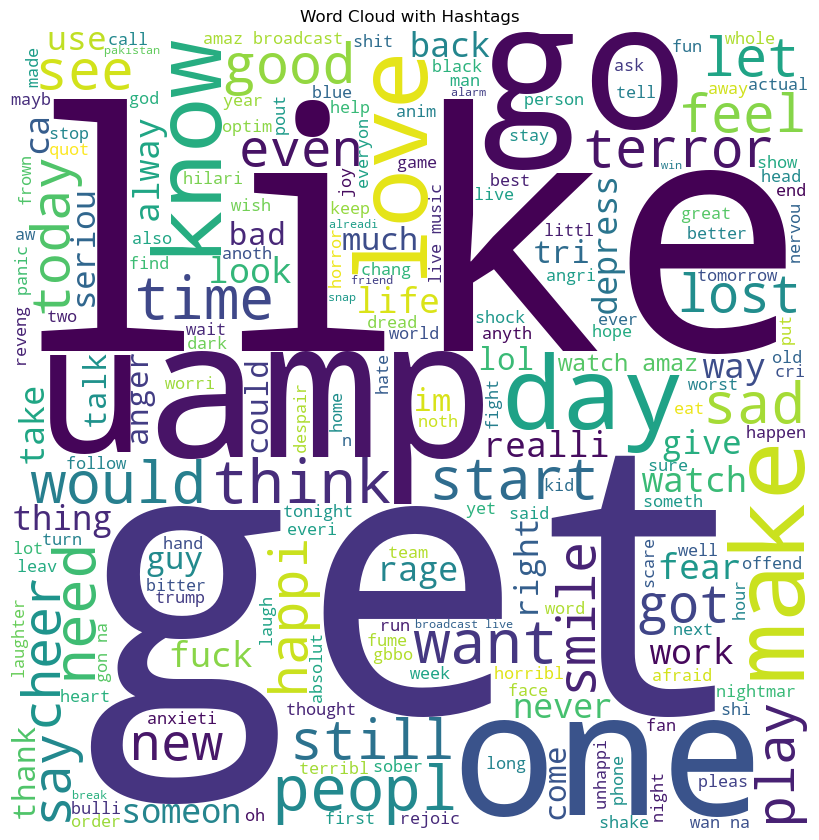

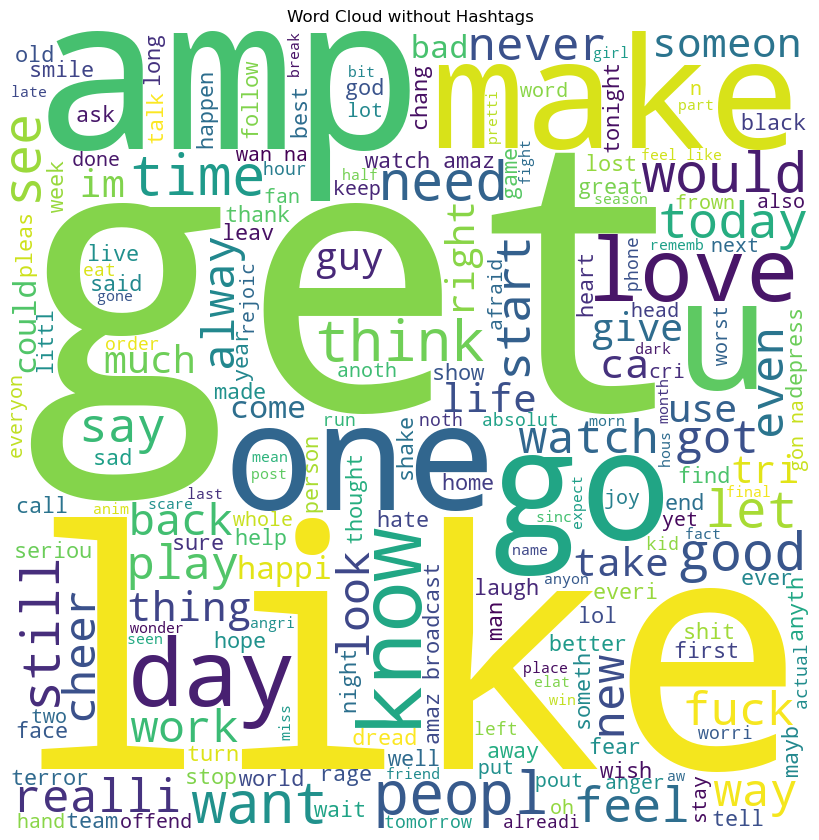

In [7]:
# Generate word clouds
# For cleaned text with hashtags
wordcloud_with_hashtags = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(' '.join(train_df['cleaned_text']))

# For cleaned text without hashtags
wordcloud_no_hashtags = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(train_df['cleaned_text_no_hashtags']))

# Plot the word cloud for cleaned text with hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_with_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud with Hashtags")
plt.show()

# Plot the word cloud for cleaned text without hashtags
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_no_hashtags) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("Word Cloud without Hashtags")
plt.show()

In [8]:
# Find the most common words for the 'cleaned_text' column which includes hashtags
sum_words_cleaned = X_train_cleaned.sum(axis=0)
words_freq_cleaned = [(word, sum_words_cleaned[0, idx]) for word, idx in vectorizer_cleaned.vocabulary_.items()]
words_freq_cleaned = sorted(words_freq_cleaned, key = lambda x: x[1], reverse=True)

# Get the top 10 most common words
common_words_with_hashtags = words_freq_cleaned[:10]

# Find the most common words for the 'cleaned_text_no_hashtags' column which excludes hashtags
sum_words_no_hashtags = X_train_no_hashtags.sum(axis=0)
words_freq_no_hashtags = [(word, sum_words_no_hashtags[0, idx]) for word, idx in vectorizer_no_hashtags.vocabulary_.items()]
words_freq_no_hashtags = sorted(words_freq_no_hashtags, key = lambda x: x[1], reverse=True)

# Get the top 10 most common words
common_words_without_hashtags = words_freq_no_hashtags[:10]

# Display the most common words with their counts for both versions
print("Most common words with hashtags:")
for word, freq in common_words_with_hashtags:
    print(word, freq)

print("\nMost common words without hashtags:")
for word, freq in common_words_without_hashtags:
    print(word, freq)

Most common words with hashtags:
like 253
get 227
amp 182
go 164
make 155
one 149
day 144
watch 141
love 138
time 130

Most common words without hashtags:
like 250
get 227
amp 182
go 164
make 154
one 149
day 144
watch 140
time 127
know 126


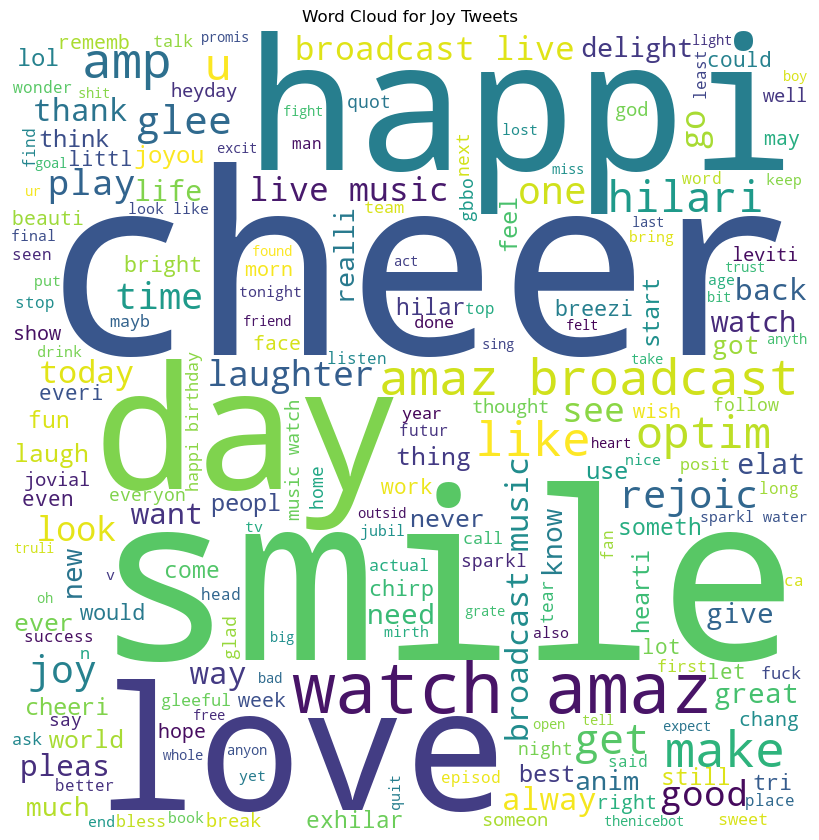

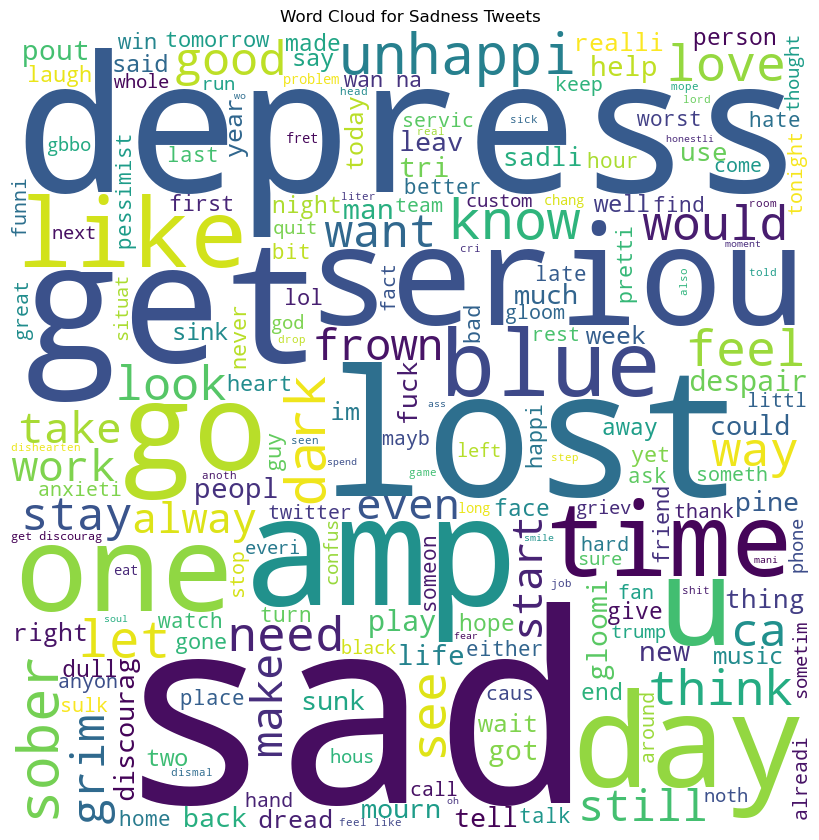

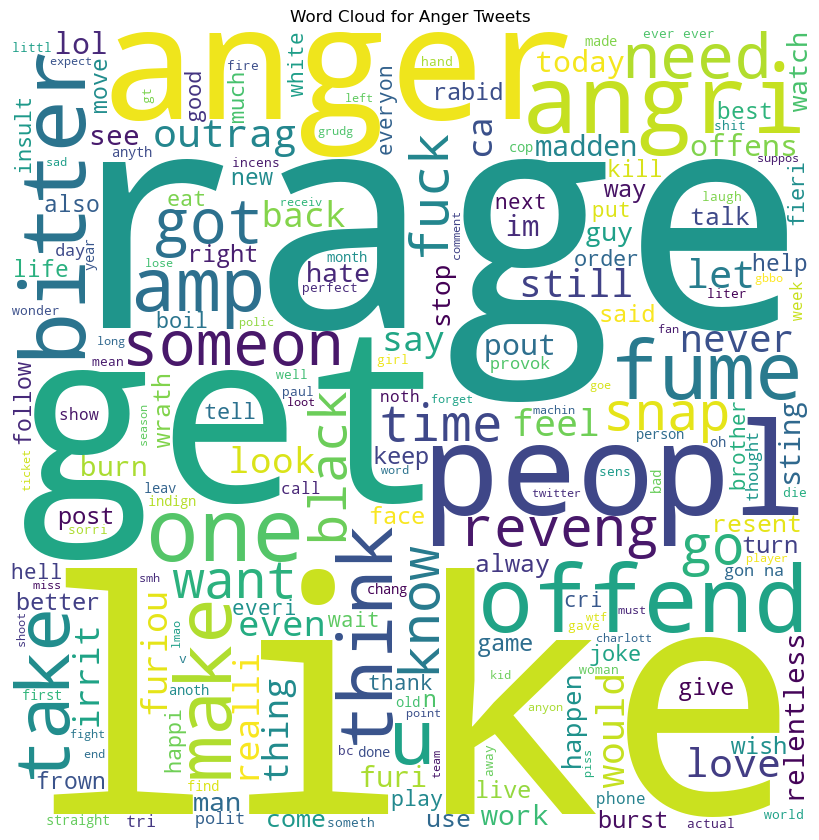

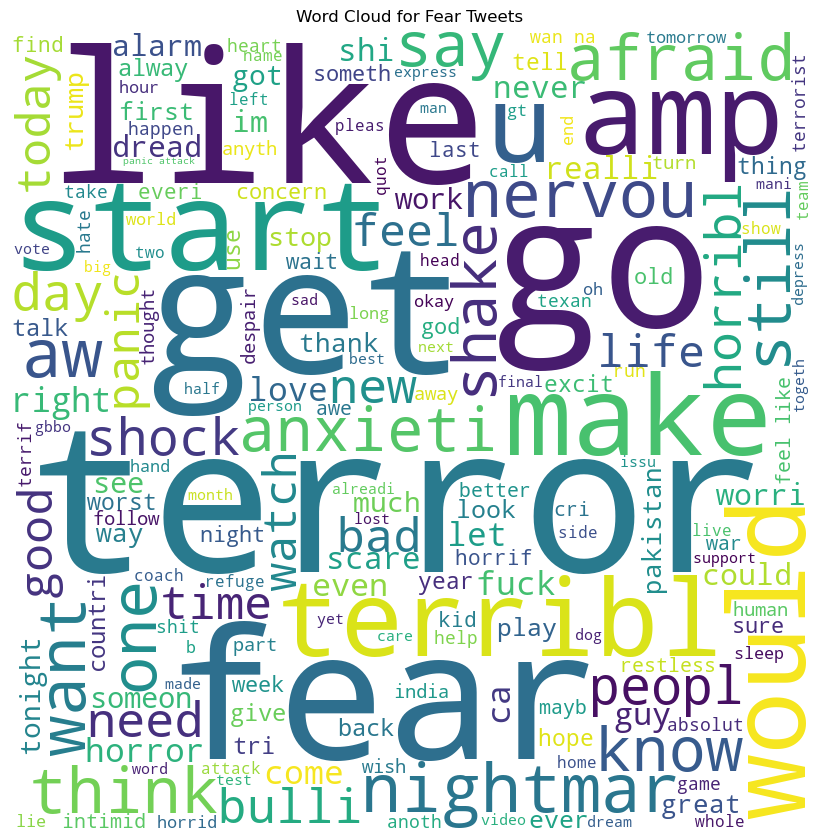

In [9]:
# Filter the DataFrame for each class and concatenate texts
joy_texts = ' '.join(train_df[train_df['label'] == 'joy']['cleaned_text'])
sadness_texts = ' '.join(train_df[train_df['label'] == 'sadness']['cleaned_text'])
anger_texts = ' '.join(train_df[train_df['label'] == 'anger']['cleaned_text'])
fear_texts = ' '.join(train_df[train_df['label'] == 'fear']['cleaned_text'])

# Function to generate and display word cloud
def generate_word_cloud(texts, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          stopwords = stop_words, 
                          min_font_size = 10).generate(texts)
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

# Generate and display word clouds for each emotion label
generate_word_cloud(joy_texts, "Word Cloud for Joy Tweets")
generate_word_cloud(sadness_texts, "Word Cloud for Sadness Tweets")
generate_word_cloud(anger_texts, "Word Cloud for Anger Tweets")
generate_word_cloud(fear_texts, "Word Cloud for Fear Tweets")

In [10]:
# Function to get most common words by class
def get_most_common_words_by_class(class_name, data, text_column, n_most_common):
    # Filter the DataFrame for the given class
    class_texts = ' '.join(data[data['label'] == class_name][text_column])
    
    # Tokenize the filtered texts
    tokens = word_tokenize(class_texts)
    
    # Create a counter object to count word frequencies in the class
    word_counts = Counter(tokens)
    
    # Exclude stop words and get the most common words
    common_words = word_counts.most_common(n_most_common)
    
    return common_words

# Set the number of top words you want to see
top_n_words = 20

# Get the most common words for each class
common_words_joy = get_most_common_words_by_class('joy', train_df, 'cleaned_text', top_n_words)
common_words_sadness = get_most_common_words_by_class('sadness', train_df, 'cleaned_text', top_n_words)
common_words_anger = get_most_common_words_by_class('anger', train_df, 'cleaned_text', top_n_words)
common_words_fear = get_most_common_words_by_class('fear', train_df, 'cleaned_text', top_n_words)

# Print the most common words for each class
print("Most common words for Joy class:", common_words_joy)
print("Most common words for Sadness class:", common_words_sadness)
print("Most common words for Anger class:", common_words_anger)
print("Most common words for Fear class:", common_words_fear)

Most common words for Joy class: [('watch', 86), ('cheer', 81), ('happi', 78), ('smile', 69), ('amaz', 63), ('love', 61), ('day', 60), ('live', 57), ('music', 55), ('like', 54), ('broadcast', 54), ('make', 53), ('amp', 52), ('good', 44), ('optim', 41), ('hilari', 38), ('get', 37), ('look', 34), ('glee', 34), ('rejoic', 33)]
Most common words for Sadness class: [('sad', 77), ('depress', 70), ('get', 63), ('lost', 61), ('amp', 46), ('like', 42), ('seriou', 42), ('time', 41), ('day', 40), ('go', 36), ('one', 35), ('feel', 33), ('blue', 33), ('unhappi', 32), ('sober', 32), ('know', 31), ('dark', 31), ('good', 28), ('let', 27), ('see', 26)]
Most common words for Anger class: [('like', 70), ('rage', 64), ('get', 55), ('anger', 53), ('peopl', 51), ('angri', 47), ('offend', 47), ('bitter', 44), ('one', 43), ('fume', 35), ('got', 35), ('reveng', 34), ('make', 32), ('think', 30), ('amp', 30), ('take', 29), ('need', 29), ('someon', 28), ('know', 28), ('go', 27)]
Most common words for Fear class: 

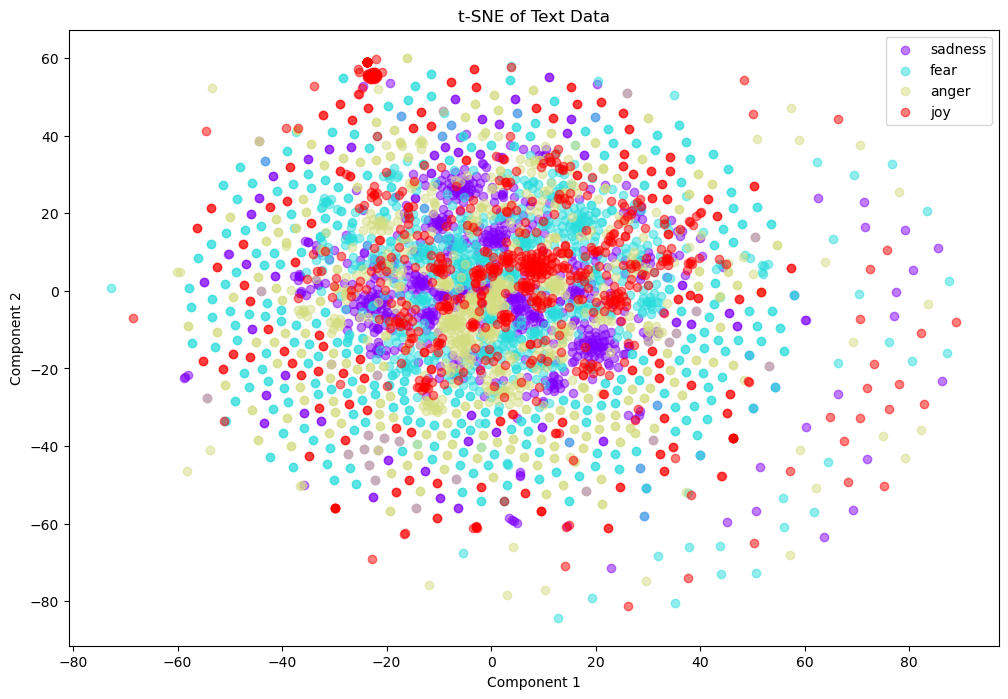

In [11]:
# Assuming X_train_cleaned is a CSR (Compressed Sparse Row) matrix
if scipy.sparse.issparse(X_train_cleaned):  # Better general check for any sparse format
    X_dense = X_train_cleaned.toarray()  # Convert any sparse matrix to a dense ndarray
else:
    X_dense = np.asarray(X_train_cleaned)  # Ensure X_train_cleaned is an ndarray

# Now X_dense is definitely in the right format for t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=40)
transformed_vectors = tsne_model.fit_transform(X_dense)

# The rest of your plotting code here, assuming you have 'labels' array available
# ...

# For the purpose of visualization, let's assume 'label' is an array of labels
labels = train_df['label'].values # make sure this matches your data's label format

# Plot the transformed vectors with their corresponding labels
plt.figure(figsize=(12, 8))
unique_labels = list(set(labels))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    indices = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(transformed_vectors[indices, 0], transformed_vectors[indices, 1], color=colors[i], label=label, alpha=0.5)

plt.legend()
plt.title('t-SNE of Text Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [12]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)

# Create a pipeline with a TF-IDF vectorizer and a Multinomial Naive Bayes classifier
pipeline = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = pipeline.predict(X_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.648686030428769

Classification Report:
               precision    recall  f1-score   support

       anger       0.84      0.60      0.70       154
        fear       0.49      0.97      0.65       223
         joy       0.97      0.56      0.71       185
     sadness       0.88      0.35      0.50       161

    accuracy                           0.65       723
   macro avg       0.79      0.62      0.64       723
weighted avg       0.77      0.65      0.64       723

